In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
MSF = pd.read_csv('MSF_1996_2023_original.csv')
MSF.columns

Index(['PERMNO', 'date', 'SHRCD', 'SICCD', 'TICKER', 'COMNAM', 'PERMCO',
       'CUSIP', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'BID', 'ASK', 'SHROUT',
       'RETX', 'vwretd'],
      dtype='object')

In [3]:
compustats = pd.read_csv('compustat.csv')

In [4]:
ccm = pd.read_csv('ccm.csv')
ccm['LINKDT'] = pd.to_datetime(ccm['LINKDT'], errors='coerce')
ccm['LINKENDDT'] = pd.to_datetime(ccm['LINKENDDT'], errors='coerce')

ccm_active = ccm[
    (ccm['LINKDT'] <= '2023-12-31') & 
    ((ccm['LINKENDDT'].isna()) | (ccm['LINKENDDT'] >= '1996-01-01'))
]
compustat_mapped = pd.merge(compustats, ccm_active, on='gvkey', how='inner')

In [5]:
ccm.columns

Index(['gvkey', 'sic', 'LINKPRIM', 'LIID', 'LINKTYPE', 'LPERMNO', 'LPERMCO',
       'LINKDT', 'LINKENDDT'],
      dtype='object')

In [6]:
MSF['date'] = pd.to_datetime(MSF['date'])
compustat_mapped['datadate'] = pd.to_datetime(compustat_mapped['datadate'])

final_data = pd.merge(
    compustat_mapped,
    MSF,
    left_on=['LPERMNO', 'datadate'],
    right_on=['PERMNO', 'date'],
    how='inner'
)

print("Final data shape:", final_data.shape)
print("Final data columns:", final_data.columns)

Final data shape: (189955, 81)
Final data columns: Index(['gvkey', 'datadate', 'fyearq', 'fqtr', 'fyr', 'indfmt', 'consol',
       'popsrc', 'datafmt', 'tic', 'cusip', 'conm', 'curcdq', 'datacqtr',
       'datafqtr', 'actq', 'aoq', 'apq', 'atq', 'ceqq', 'cheq', 'chq', 'cogsq',
       'dlttq', 'dvintfq', 'epsfi12', 'ibadjq', 'ibcomq', 'ibq', 'intaccq',
       'invtq', 'lctq', 'lltq', 'loq', 'ltq', 'niq', 'nopiq', 'oibdpq', 'piq',
       'ppentq', 'pstkq', 'rectq', 'saleq', 'seqq', 'txtq', 'xaccq', 'capxy',
       'niy', 'oancfy', 'revty', 'cik', 'costat', 'dvpspq', 'mkvaltq', 'prccq',
       'sic', 'LINKPRIM', 'LIID', 'LINKTYPE', 'LPERMNO', 'LPERMCO', 'LINKDT',
       'LINKENDDT', 'PERMNO', 'date', 'SHRCD', 'SICCD', 'TICKER', 'COMNAM',
       'PERMCO', 'CUSIP', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'BID', 'ASK',
       'SHROUT', 'RETX', 'vwretd'],
      dtype='object')


In [7]:
print("Summary of NaN values:")
print(final_data.isna().sum())

print("Summary of zero values:")
zero_counts = (final_data == 0).sum()
print(zero_counts)

numeric_columns = final_data.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_columns:
    final_data[col].replace(0, np.nan, inplace=True)


final_data[numeric_columns] = final_data[numeric_columns].fillna(final_data[numeric_columns].median())

categorical_columns = ['TICKER', 'COMNAM', 'sic', 'LINKPRIM', 'LINKTYPE']
for col in categorical_columns:
    if col in final_data.columns:
        final_data[col].fillna(final_data[col].mode()[0], inplace=True)

print("After cleaning, NaN values per column:")
print(final_data.isna().sum())

print("After cleaning, zero values per column:")
zero_counts = (final_data == 0).sum()
print(zero_counts)


Summary of NaN values:
gvkey          0
datadate       0
fyearq         0
fqtr          48
fyr            0
            ... 
BID         7215
ASK         7215
SHROUT         5
RETX         225
vwretd         0
Length: 81, dtype: int64
Summary of zero values:
gvkey       0
datadate    0
fyearq      0
fqtr        0
fyr         0
           ..
BID         0
ASK         0
SHROUT      0
RETX        0
vwretd      0
Length: 81, dtype: int64
After cleaning, NaN values per column:
gvkey         0
datadate      0
fyearq        0
fqtr          0
fyr           0
           ... 
BID           0
ASK           0
SHROUT        0
RETX        225
vwretd        0
Length: 81, dtype: int64
After cleaning, zero values per column:
gvkey       0
datadate    0
fyearq      0
fqtr        0
fyr         0
           ..
BID         0
ASK         0
SHROUT      0
RETX        0
vwretd      0
Length: 81, dtype: int64


In [8]:
final_data['datadate'] = pd.to_datetime(final_data['datadate'], errors='coerce')
final_data['date'] = pd.to_datetime(final_data['date'], errors='coerce')

In [9]:
final_data.head(1000).to_csv('first_1000_rows.csv', index=False)

In [10]:
df = final_data
df = df.drop_duplicates(subset=['PERMNO', 'date'])

In [11]:
import pandas as pd
import numpy as np

# Ensure date columns are in datetime format
final_data['datadate'] = pd.to_datetime(final_data['datadate'], errors='coerce')
final_data['date'] = pd.to_datetime(final_data['date'], errors='coerce')

# Create a new DataFrame to store expanded monthly data
monthly_data = []

# Loop through each group of gvkey and PERMNO
for (gvkey, permno), group in final_data.groupby(['gvkey', 'PERMNO']):
    # Sort data by date
    group = group.sort_values(by='datadate')
    
    # Drop duplicates in the 'datadate' column to avoid reindexing issues
    group = group[~group['datadate'].duplicated(keep='first')]
    
    # Generate a monthly date range
    min_date = group['datadate'].min()
    max_date = group['datadate'].max()
    monthly_dates = pd.date_range(start=min_date, end=max_date, freq='M')  # Generate monthly range
    
    # Reindex the group to include monthly dates
    group = group.set_index('datadate')  # Set datadate as index
    monthly_group = group.reindex(monthly_dates)  # Reindex to monthly
    monthly_group.index.name = 'datadate'  # Rename the index to datadate
    
    # Handle numeric columns
    numeric_cols = group.select_dtypes(include=['float64', 'int64']).columns
    monthly_group[numeric_cols] = monthly_group[numeric_cols].interpolate(method='linear')  # Interpolate missing values
    monthly_group[numeric_cols] = monthly_group[numeric_cols].fillna(method='ffill')  # Forward fill remaining NaN values
    
    # Handle non-numeric columns
    non_numeric_cols = group.select_dtypes(exclude=['float64', 'int64']).columns
    monthly_group[non_numeric_cols] = monthly_group[non_numeric_cols].fillna(method='ffill')  # Forward fill for non-numeric values
    
    # Append to the result list
    monthly_data.append(monthly_group.reset_index())

# Concatenate all groups into a single DataFrame
monthly_data = pd.concat(monthly_data, axis=0).reset_index(drop=True)

# Check the result
print("Original data shape:", final_data.shape)
print("Expanded monthly data shape:", monthly_data.shape)

# Display the first few rows of the expanded data
print(monthly_data.head())
monthly_data.to_csv('monthly_data.csv', index=False)

Original data shape: (189955, 81)
Expanded monthly data shape: (709206, 81)
    datadate   gvkey       fyearq      fqtr  fyr indfmt consol popsrc datafmt  \
0 1996-02-29  1004.0  1995.000000  3.000000  5.0   INDL      C      D     STD   
1 1996-03-31  1004.0  1995.000000  3.333333  5.0   INDL      C      D     STD   
2 1996-04-30  1004.0  1995.000000  3.666667  5.0   INDL      C      D     STD   
3 1996-05-31  1004.0  1995.000000  4.000000  5.0   INDL      C      D     STD   
4 1996-06-30  1004.0  1995.111111  3.888889  5.0   INDL      C      D     STD   

   tic  ...      BIDLO      ASKHI        PRC           VOL        RET  \
0  AIR  ...  19.625000  20.750000  19.625000   8857.000000  -0.048485   
1  AIR  ...  19.791667  21.708333  20.458333   9285.000000  -0.048485   
2  AIR  ...  19.958333  22.666667  21.291667   9713.000000  -0.048485   
3  AIR  ...  20.125000  23.625000  22.125000  10141.000000   0.085890   
4  AIR  ...  20.625000  24.000000  22.500000  11729.111111   0.085890   

In [12]:
df = pd.read_csv('monthly_data.csv')

In [13]:
columns_to_fill = ['actq', 'atq', 'ceqq', 'ltq', 'oibdpq', 'capxy', 'ibq', 'PRC', 'RET', 'SHROUT']
columns_to_fill = [col for col in columns_to_fill if col in df.columns]
print(df['PERMNO'].dtype)
print(df[columns_to_fill].dtypes)

float64
actq      float64
atq       float64
ceqq      float64
ltq       float64
oibdpq    float64
capxy     float64
ibq       float64
PRC       float64
RET        object
SHROUT    float64
dtype: object


In [14]:
for col in columns_to_fill:
    df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
print(df[columns_to_fill].isnull().sum())
print(df[columns_to_fill].head())

actq      0
atq       0
ceqq      0
ltq       0
oibdpq    0
capxy     0
ibq       0
PRC       0
RET       0
SHROUT    0
dtype: int64
      actq         atq        ceqq         ltq  oibdpq     capxy       ibq  \
0  329.852  429.271000  202.967000  226.304000  10.735  5.050000  4.089000   
1  332.572  432.129333  203.523000  228.606333  11.221  5.882333  4.394667   
2  335.292  434.987667  204.079000  230.908667  11.707  6.714667  4.700333   
3  338.012  437.846000  204.635000  233.211000  12.193  7.547000  5.006000   
4  345.981  447.402222  211.236333  236.165889  12.451  9.624333  5.109778   

         PRC        RET        SHROUT  
0  19.625000  -0.048485  15955.000000  
1  20.458333  -0.048485  15978.333333  
2  21.291667  -0.048485  16001.666667  
3  22.125000   0.085890  16025.000000  
4  22.500000   0.085890  16240.222222  


In [15]:
# Ensure all columns needed for calculations are numeric
numeric_columns = [
    'PRC', 'SHROUT', 'atq', 'cheq', 'ltq', 'ceqq', 'pstkq',
    'capxy', 'ibq', 'oibdpq', 'actq', 'lctq', 'invtq', 'RET', 'VOL'
]

# Convert columns to numeric, coercing errors to NaN
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Debugging: Check data types after conversion
print("Data types after conversion to numeric:")
print(df[numeric_columns].dtypes)

Data types after conversion to numeric:
PRC       float64
SHROUT    float64
atq       float64
cheq      float64
ltq       float64
ceqq      float64
pstkq     float64
capxy     float64
ibq       float64
oibdpq    float64
actq      float64
lctq      float64
invtq     float64
RET       float64
VOL       float64
dtype: object


In [17]:
# Fill missing values with forward and backward filling
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

df.replace(0, np.nan, inplace=True)

# 1. Accruals
df['NOA'] = df['atq'] - df['cheq'] - (df['atq'] - df['ltq'] - df['ceqq'] - df['pstkq'])
df['Accruals'] = (df['NOA'] - df['NOA'].shift(1)) / df['NOA'].shift(1)
# 2. Gross profitability
df['Gross_Profitability'] = (df['saleq'] - df['cogsq']) / df['atq']
# 3. Market capitalization
df['Market_Capitalization'] = df['prccq'].abs() * df['SHROUT']
# 4. Book-to-market ratio
df['Book_to_Market'] = df['ceqq'] / df['Market_Capitalization']
# 5. Short-term reversal
df['Short_Term_Reversal'] = df['RET'].shift(1)
# 6. Momentum (12-month rolling sum excluding the last month)
df['Momentum'] = df['RET'].rolling(window=12, min_periods=1).sum() - df['RET'].shift(1)
# 7. Long-term reversal (5-year rolling sum excluding the last year)
df['Long_Term_Reversal'] = df['RET'].rolling(window=60, min_periods=1).sum() - df['RET'].rolling(window=12, min_periods=1).sum()
# 8. Asset growth
df['Asset_Growth'] = df['atq'].pct_change()
# 9. Investment ratio
df['Investment_Ratio'] = df['capxy'] / df['atq']
# 10. Leverage
df['Leverage'] = df['ltq'] / df['ceqq']
# 11. Earnings yield
df['Earnings_Yield'] = df['ibq'] / df['prccq']
# 12. Dividend/price
df['Dividend_Price'] = df['dvpspq'] / df['prccq']
# 13. Cash flow/price
df['Cash_Flow_Price'] = df['oibdpq'] / df['prccq']
# 14. Illiquidity
df['Illiquidity'] = df['RET'].abs() / df['VOL']
# 15. Return on equity (ROE)
df['ROE'] = df['ibq'] / df['ceqq']
# 16. Return on assets (ROA)
df['ROA'] = df['ibq'] / df['atq']
# 17. Current ratio
df['Current_Ratio'] = df['actq'] / df['lctq']
# 18. Quick ratio
df['Quick_Ratio'] = (df['actq'] - df['invtq']) / df['lctq']
# 19. Net profit margin
df['Net_Profit_Margin'] = df['ibq'] / df['saleq']
# 20. Gross margin
df['Gross_Margin'] = (df['saleq'] - df['cogsq']) / df['saleq']
# Display calculated factors
print(df[['Accruals', 'Gross_Profitability', 'Market_Capitalization', 
          'Book_to_Market', 'Short_Term_Reversal', 'Momentum', 
          'Long_Term_Reversal', 'Asset_Growth', 'Investment_Ratio', 
          'Leverage', 'Earnings_Yield', 'Dividend_Price', 'Cash_Flow_Price', 
          'Illiquidity', 'ROE', 'ROA', 'Current_Ratio', 'Quick_Ratio', 
          'Net_Profit_Margin', 'Gross_Margin']].head())


   Accruals  Gross_Profitability  Market_Capitalization  Book_to_Market  \
0       NaN             0.057980          313116.844526        0.000648   
1  0.002177             0.060355          326890.041482        0.000623   
2  0.002172             0.062698          340702.127335        0.000599   
3  0.002167             0.065011          354553.102084        0.000577   
4  0.017528             0.064338          365404.938053        0.000578   

   Short_Term_Reversal  Momentum  Long_Term_Reversal  Asset_Growth  \
0                  NaN       NaN                 0.0           NaN   
1            -0.048485 -0.048485                 0.0      0.006659   
2            -0.048485 -0.096970                 0.0      0.006615   
3            -0.048485 -0.011080                 0.0      0.006571   
4             0.085890 -0.059565                 0.0      0.021826   

   Investment_Ratio  Leverage  Earnings_Yield  Dividend_Price  \
0          0.011764  1.114979        0.208357        0.006115  

In [18]:
# Map existing columns to new calculated columns based on availability
df['ATQH'] = df['atq']  # Total Assets
df['SEQQH'] = df['ceqq']  # Total Stockholders Equity
df['ICAPTQH'] = df['ceqq'] + df['ltq']  # Total Invested Capital
df['PSTKRQH'] = df['pstkq']  # Redeemable Preferred/Preference Stock
df['TEQQH'] = df['ceqq']  # Total Stockholders Equity
df['PPENTQH'] = df['ppentq']  # Net Property, Plant, and Equipment
df['LTQH'] = df['ltq']  # Total Liabilities
df['PSTKQH'] = df['pstkq']  # Total Preferred/Preference Stock
df['CEQQH'] = df['ceqq']  # Total Common/Ordinary Equity

# Handle calculations based on column availability
if 'invtq' in df.columns:
    df['AOQH'] = df['atq'] - df['lctq'] - df['invtq']  # Total Other Assets
else:
    df['AOQH'] = df['atq'] - df['lctq']  # Approximation if 'invtq' is missing

if 'dlttq' in df.columns:
    df['DLTTQH'] = df['dlttq']  # Total Long-term Debt

df['LOQH'] = df['loq']  # Total Other Liabilities
df['ACOQH'] = df['actq']  # Total Other Current Assets
df['CHEQH'] = df['cheq']  # Cash and Short-term Investments
df['LCOQH'] = df['lctq']  # Total Other Current Liabilities
df['APQH'] = df['apq']  # Accounts Payable

if 'saleq' in df.columns:
    df['SALEQH'] = df['saleq']  # Sales/Turnover (Net)

if 'oibdpq' in df.columns:
    df['XIDOQH'] = df['oibdpq']  # Extraordinary Items and Discontinued Operations
    df['NOPIQH'] = df['oibdpq']  # Non-operating Income (Expense)

df['IBQH'] = df['ibq']  # Income Before Extraordinary Items
df['IBADJQH'] = df['ibadjq']  # Adjusted Income Before Extraordinary Items
df['NIQH'] = df['niq']  # Net Income (Loss)
df['IBCOMQH'] = df['ibcomq']  # Income Before Extraordinary Items, Available for Common Stock Equivalents
df['PIQH'] = df['piq']  # Pretax Income
df['TXTQH'] = df['txtq']  # Total Income Taxes

if 'dvintfq' in df.columns:
    df['DOQH'] = df['dvintfq']  # Discontinued Operations

if 'dvpspq' in df.columns:
    df['DVQH'] = df['dvpspq']  # Cash Dividends

In [20]:
# Ensure relevant columns are numeric
columns_to_ensure_numeric = ['niq', 'SHROUT', 'PERMNO']
for col in columns_to_ensure_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Debugging: Check data types
print("Data types after conversion to numeric:")
print(df[columns_to_ensure_numeric].dtypes)

# Sort data by PERMNO and datadate to ensure proper temporal alignment
df = df.sort_values(by=['PERMNO', 'datadate'])

# Debugging: Check first few rows after sorting
print("First few rows after sorting:")
print(df[['PERMNO', 'datadate', 'niq', 'SHROUT']].head(10))

# Debugging: Check for missing or non-numeric data in NIQ and SHROUT
print("Non-numeric or missing NIQ values:", df['niq'].isna().sum())
print("Non-numeric or missing SHROUT values:", df['SHROUT'].isna().sum())

# Calculate SUE (Quarterly Unexpected Earnings Surprise) manually
try:
    # Calculate earnings per share (EPS) for the current quarter
    df['EPS'] = df['niq'] / df['SHROUT']
    
    # Calculate EPS for the same quarter last year
    df['EPS_lag'] = df.groupby('PERMNO')['EPS'].shift(4)
    
    # Calculate the standard deviation of EPS for the past 8 quarters
    df['EPS_std'] = (
        df.groupby('PERMNO')['EPS']
        .rolling(window=8, min_periods=1)
        .std()
        .reset_index(level=0, drop=True)
    )
    
    # Calculate SUE
    df['SUE'] = (df['EPS'] - df['EPS_lag']) / df['EPS_std']
    
    # Debugging: Display first few rows of data for inspection
    print("First few rows of data after SUE calculation:")
    print(df[['PERMNO', 'datadate', 'niq', 'SHROUT', 'EPS', 'EPS_lag', 'EPS_std', 'SUE']].head(10))
except Exception as e:
    print("Error during SUE calculation:", str(e))

Data types after conversion to numeric:
niq       float64
SHROUT    float64
PERMNO    float64
dtype: object
First few rows after sorting:
         PERMNO    datadate       niq       SHROUT
232389  10026.0  1996-09-30  2.541000  8749.000000
232390  10026.0  1996-10-31  1.731000  8749.333333
232391  10026.0  1996-11-30  0.921000  8749.666667
232392  10026.0  1996-12-31  0.111000  8750.000000
232393  10026.0  1997-01-31  0.376000  8755.666667
232394  10026.0  1997-02-28  0.641000  8761.333333
232395  10026.0  1997-03-31  0.906000  8767.000000
232396  10026.0  1997-04-30  1.656667  8777.000000
232397  10026.0  1997-05-31  2.407333  8787.000000
232398  10026.0  1997-06-30  3.158000  8797.000000
Non-numeric or missing NIQ values: 36
Non-numeric or missing SHROUT values: 0
First few rows of data after SUE calculation:
         PERMNO    datadate       niq       SHROUT       EPS   EPS_lag  \
232389  10026.0  1996-09-30  2.541000  8749.000000  0.000290       NaN   
232390  10026.0  1996-10-31  

In [21]:
# Ensure relevant columns are numeric
columns_to_ensure_numeric = ['niq', 'SHROUT', 'PERMNO']
for col in columns_to_ensure_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Debugging: Check data types
print("Data types after conversion to numeric:")
print(df[columns_to_ensure_numeric].dtypes)

# Sort data by PERMNO and datadate to ensure proper temporal alignment
df = df.sort_values(by=['PERMNO', 'datadate'])

# Debugging: Check first few rows after sorting
print("First few rows after sorting:")
print(df[['PERMNO', 'datadate', 'niq', 'SHROUT']].head(10))

# Debugging: Check for missing or non-numeric data in niq and SHROUT
print("Non-numeric or missing niq values:", df['niq'].isna().sum())
print("Non-numeric or missing SHROUT values:", df['SHROUT'].isna().sum())

# Calculate SUE (Quarterly Unexpected Earnings Surprise)
try:
    df['EPS'] = df['niq'] / df['SHROUT']  # Earnings per share (current quarter)
    df['EPS_lag'] = df.groupby('PERMNO')['EPS'].shift(4)  # EPS of the same quarter last year
    df['EPS_std'] = (
        df.groupby('PERMNO')['EPS']
        .rolling(window=8, min_periods=1)
        .std()
        .reset_index(level=0, drop=True)  # Rolling std for the past 8 quarters
    )
    # Calculate SUE
    df['SUE'] = (df['EPS'] - df['EPS_lag']) / df['EPS_std']
except Exception as e:
    print("Error during SUE calculation:", str(e))

# Debugging: Display first few rows of data for inspection
print("First few rows of data after SUE calculation:")
print(df[['PERMNO', 'datadate', 'niq', 'SHROUT', 'EPS', 'EPS_lag', 'EPS_std', 'SUE']].head(10))

Data types after conversion to numeric:
niq       float64
SHROUT    float64
PERMNO    float64
dtype: object
First few rows after sorting:
         PERMNO    datadate       niq       SHROUT
232389  10026.0  1996-09-30  2.541000  8749.000000
232390  10026.0  1996-10-31  1.731000  8749.333333
232391  10026.0  1996-11-30  0.921000  8749.666667
232392  10026.0  1996-12-31  0.111000  8750.000000
232393  10026.0  1997-01-31  0.376000  8755.666667
232394  10026.0  1997-02-28  0.641000  8761.333333
232395  10026.0  1997-03-31  0.906000  8767.000000
232396  10026.0  1997-04-30  1.656667  8777.000000
232397  10026.0  1997-05-31  2.407333  8787.000000
232398  10026.0  1997-06-30  3.158000  8797.000000
Non-numeric or missing niq values: 36
Non-numeric or missing SHROUT values: 0
First few rows of data after SUE calculation:
         PERMNO    datadate       niq       SHROUT       EPS   EPS_lag  \
232389  10026.0  1996-09-30  2.541000  8749.000000  0.000290       NaN   
232390  10026.0  1996-10-31  

In [22]:
# Ensure the 'NOA' column is numeric
df['NOA'] = pd.to_numeric(df['NOA'], errors='coerce')

# Debugging: Check data type of the 'NOA' column
print("Data type of NOA column after conversion to numeric:")
print(df['NOA'].dtypes)

# Fill NaN values in 'NOA' using forward and backward filling, grouped by 'PERMNO'
try:
    df['NOA'] = (
        df.groupby('PERMNO')['NOA']
        .apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
    )
    print("NaN values in NOA filled successfully.")
except Exception as e:
    print(f"Error during NaN filling in NOA: {e}")

# Replace zero values with NaN and fill them using forward and backward filling
df['NOA'] = df['NOA'].replace(0, pd.NA)
try:
    df['NOA'] = (
        df.groupby('PERMNO')['NOA']
        .apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
    )
    print("Zero values in NOA filled successfully.")
except Exception as e:
    print(f"Error during zero value filling in NOA: {e}")

# Calculate Scaled_NOA
try:
    df['Scaled_NOA'] = df['NOA'] / df.groupby('PERMNO')['NOA'].shift(1)
    print("Scaled_NOA calculated successfully.")
except Exception as e:
    print("Error during Scaled_NOA calculation:", str(e))

Data type of NOA column after conversion to numeric:
float64
Error during NaN filling in NOA: incompatible index of inserted column with frame index
Error during zero value filling in NOA: incompatible index of inserted column with frame index
Scaled_NOA calculated successfully.


In [23]:
# Ensure the 'SHROUT' column is numeric
df['SHROUT'] = pd.to_numeric(df['SHROUT'], errors='coerce')

# Debugging: Check data types after conversion
print("Data types after conversion to numeric:")
print(df['SHROUT'].dtypes)

# Fill NaN values using forward and backward filling, grouped by PERMNO
try:
    df['SHROUT'] = df.groupby('PERMNO')['SHROUT'].apply(
        lambda group: group.fillna(method='ffill').fillna(method='bfill')
    )
    print("NaN values in SHROUT filled successfully.")
except Exception as e:
    print(f"Error during NaN filling in SHROUT: {e}")

# Debugging: Check for remaining NaN values after filling
nan_counts = df['SHROUT'].isna().sum()
print("NaN value counts in SHROUT after filling:")
print(nan_counts)

# Replace zero values with NaN to use the same filling method
df['SHROUT'] = df['SHROUT'].replace(0, pd.NA)

# Fill zero values (now NaN) using forward and backward filling, grouped by PERMNO
try:
    df['SHROUT'] = df.groupby('PERMNO')['SHROUT'].apply(
        lambda group: group.fillna(method='ffill').fillna(method='bfill')
    )
    print("Zero values in SHROUT filled successfully.")
except Exception as e:
    print(f"Error during zero value filling in SHROUT: {e}")

# Debugging: Check for remaining zero values after filling
zero_counts = df['SHROUT'].isin([0]).sum()
print("Zero value counts in SHROUT after filling:")
print(zero_counts)

# Calculate Share Issuance
try:
    df['Share_Issuance'] = (
        df['SHROUT'] / df.groupby('PERMNO')['SHROUT'].shift(1) - 1
    )
    print("Share_Issuance calculated successfully.")
except Exception as e:
    print("Error during Share Issuance calculation:", str(e))

# Debugging: Check first few rows after calculating Share Issuance
print("First few rows after calculating Share Issuance:")
print(df[['PERMNO', 'date', 'SHROUT', 'Share_Issuance']].head(10))


Data types after conversion to numeric:
float64
Error during NaN filling in SHROUT: incompatible index of inserted column with frame index
NaN value counts in SHROUT after filling:
0
Error during zero value filling in SHROUT: incompatible index of inserted column with frame index
Zero value counts in SHROUT after filling:
0
Share_Issuance calculated successfully.
First few rows after calculating Share Issuance:
         PERMNO        date       SHROUT  Share_Issuance
232389  10026.0  1996-09-30  8749.000000             NaN
232390  10026.0  1996-09-30  8749.333333        0.000038
232391  10026.0  1996-09-30  8749.666667        0.000038
232392  10026.0  1996-12-31  8750.000000        0.000038
232393  10026.0  1996-12-31  8755.666667        0.000648
232394  10026.0  1996-12-31  8761.333333        0.000647
232395  10026.0  1997-03-31  8767.000000        0.000647
232396  10026.0  1997-03-31  8777.000000        0.001141
232397  10026.0  1997-03-31  8787.000000        0.001139
232398  10026.0

In [24]:
# Define the numeric columns to process
numeric_columns = [
    'ACOQH', 'LCOQH', 'ATQH', 'NIQH', 'NOPIQH', 'SHROUT', 'PRC', 'LTQH', 'SALEQH'
]

# Ensure only existing columns are processed
numeric_columns = [col for col in numeric_columns if col in df.columns]

# Convert columns to numeric, coercing errors to NaN
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Debugging: Check data types after conversion
print("Data types after conversion to numeric:")
print(df[numeric_columns].dtypes)

# Fill NaN values using forward and backward filling, grouped by PERMNO
try:
    df[numeric_columns] = df.groupby('PERMNO')[numeric_columns].apply(
        lambda group: group.fillna(method='ffill').fillna(method='bfill')
    )
    print("NaN values filled successfully.")
except Exception as e:
    print(f"Error during NaN filling: {e}")

# Replace zero values with NaN to use the same filling method
df[numeric_columns] = df[numeric_columns].replace(0, pd.NA)

# Fill zero values (now NaN) using forward and backward filling, grouped by PERMNO
try:
    df[numeric_columns] = df.groupby('PERMNO')[numeric_columns].apply(
        lambda group: group.fillna(method='ffill').fillna(method='bfill')
    )
    print("Zero values filled successfully.")
except Exception as e:
    print(f"Error during zero value filling: {e}")

# Check required columns for Z-Score calculation
required_cols_z_score = ['ACOQH', 'LCOQH', 'ATQH', 'NIQH', 'NOPIQH', 'SHROUT', 'PRC', 'LTQH', 'SALEQH']
missing_cols = [col for col in required_cols_z_score if col not in df.columns]
if missing_cols:
    print(f"Error: Missing columns for Z-Score calculation: {missing_cols}")
else:
    # Calculate intermediate values
    try:
        df['Working_Capital'] = df['ACOQH'] - df['LCOQH']
        df['A'] = df['Working_Capital'] / df['ATQH']
        df['B'] = df['NIQH'] / df['ATQH']
        df['C'] = df['NOPIQH'] / df['ATQH']
        df['D'] = (df['SHROUT'] * df['PRC']) / df['LTQH']
        df['E'] = df['SALEQH'] / df['ATQH']
        
        # Debugging: Check intermediate values
        print("Intermediate values for Z-Score calculation:")
        print(df[['Working_Capital', 'A', 'B', 'C', 'D', 'E']].head(10))
        
        # Calculate Z-Score
        df['Z_Score'] = (
            1.2 * df['A'] +
            1.4 * df['B'] +
            3.3 * df['C'] +
            0.6 * df['D'] +
            1.0 * df['E']
        )
        print("Z_Score calculated successfully.")
        
        # Drop intermediate columns
        df.drop(columns=['Working_Capital', 'A', 'B', 'C', 'D', 'E'], inplace=True)
        print("Dropped intermediate columns used in Z-Score calculation.")
    except Exception as e:
        print("Error during Z-Score calculation:", str(e))


Data types after conversion to numeric:
ACOQH     float64
LCOQH     float64
ATQH      float64
NIQH      float64
NOPIQH    float64
SHROUT    float64
PRC       float64
LTQH      float64
SALEQH    float64
dtype: object
Error during NaN filling: incompatible index of inserted column with frame index
Error during zero value filling: incompatible index of inserted column with frame index
Intermediate values for Z-Score calculation:
        Working_Capital         A         B         C            D         E
232389        24.782000  0.201270  0.020637  0.062512  3559.869417  0.421724
232390        21.254000  0.172949  0.014086  0.052659  3909.143519  0.399953
232391        17.726000  0.144518  0.007509  0.042767  4266.779268  0.378098
232392        14.198000  0.115978  0.000907  0.032838  4633.079699  0.356159
232393        14.516333  0.115450  0.002990  0.036216  4074.476990  0.364537
232394        14.834667  0.114950  0.004967  0.039420  3621.536831  0.372484
232395        15.153000  0.1144

In [25]:
df

,datadate,gvkey,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,...,TXTQH,DOQH,DVQH,EPS,EPS_lag,EPS_std,SUE,Scaled_NOA,Share_Issuance,Z_Score
232389,1996-09-30,12825.0,1996.000000,4.000000,9.0,INDL,C,D,STD,JJSF,...,1.406000,1.062,0.17,0.000290,NaN,NaN,NaN,NaN,NaN,2136.820080
232390,1996-10-31,12825.0,1996.333333,3.000000,9.0,INDL,C,D,STD,JJSF,...,0.958000,1.062,0.17,0.000198,NaN,0.000065,NaN,1.028106,0.000038,2346.287096
232391,1996-11-30,12825.0,1996.666667,2.000000,9.0,INDL,C,D,STD,JJSF,...,0.510000,1.062,0.17,0.000105,NaN,0.000093,NaN,1.027337,0.000038,2560.770725
232392,1996-12-31,12825.0,1997.000000,1.000000,9.0,INDL,C,D,STD,JJSF,...,0.062000,1.062,0.17,0.000013,NaN,0.000120,NaN,1.026610,0.000038,2780.452786
232393,1997-01-31,12825.0,1997.000000,1.333333,9.0,INDL,C,D,STD,JJSF,...,0.219667,1.062,0.17,0.000043,0.000290,0.000114,-2.164498,1.025306,0.000648,2445.312970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694383,2023-02-28,184996.0,2022.833333,1.333333,12.0,INDL,C,D,STD,TSLA,...,268.333333,1.062,0.17,0.000834,0.001001,0.000214,-0.776207,1.031316,0.000596,11186.983608
694384,2023-03-31,184996.0,2023.000000,1.000000,12.0,INDL,C,D,STD,TSLA,...,261.000000,1.062,0.17,0.000793,0.000959,0.000131,-1.273138,1.030365,0.000595,10493.338996
694385,2023-04-30,184996.0,2023.000000,1.333333,12.0,INDL,C,D,STD,TSLA,...,281.666667,1.062,0.17,0.000812,0.000917,0.000091,-1.152203,1.017608,0.000493,11333.088477
694386,2023-05-31,184996.0,2023.000000,1.666667,12.0,INDL,C,D,STD,TSLA,...,302.333333,1.062,0.17,0.000832,0.000876,0.000074,-0.589172,1.017303,0.000493,12161.823123


In [26]:
# Check for zero and NaN values in each column
zero_counts = df.isin([0]).sum()
nan_counts = df.isna().sum()

# Print the counts of zero and NaN values for each column
print("Zero value counts in each column:")
print(zero_counts)
print("\nNaN value counts in each column:")
print(nan_counts)


Zero value counts in each column:
datadate              0
gvkey                 0
fyearq                0
fqtr                  0
fyr                   0
                  ...  
EPS_std             706
SUE                 102
Scaled_NOA            0
Share_Issuance    93217
Z_Score               0
Length: 136, dtype: int64

NaN value counts in each column:
datadate              0
gvkey                 0
fyearq                0
fqtr                  0
fyr                   0
                  ...  
EPS_std            4577
SUE               18813
Scaled_NOA         4581
Share_Issuance     4577
Z_Score              56
Length: 136, dtype: int64


In [27]:
df.to_csv('final_data.csv')

In [35]:
df = pd.read_csv('dataset.csv')

In [48]:
df

,PERMNO,date,Return,Share_price,Number_of_shares_outstanding,beta,industry,mkt_cap,Industry_RET,Short_term_reversal,...,DVQH,EPS,EPS_lag,EPS_std,SUE,Share_Issuance,Scaled_NOA,Z_Score,Industry_Adjusted_Return,Mispricing_Signal
0,10028,2002-09,0.000000,1.17000,4914.0,1.048013,Rtail,5.749380e+03,-9.95,-0.082353,...,0.17,-0.000006,1.569355e-05,0.000013,-1.632882,NaN,0.999794,562.662866,0.063854,-49.669632
1,10028,2002-10,0.042735,1.22000,4914.0,0.987147,Rtail,5.995080e+03,5.82,0.000000,...,0.17,-0.000006,1.569355e-05,0.000013,-1.632882,0.000000,0.999794,562.662866,0.003555,-63.734440
2,10028,2002-11,-0.032787,1.18000,4914.0,1.240796,Rtail,5.798520e+03,2.97,0.042735,...,0.17,-0.000006,1.569355e-05,0.000013,-1.632882,0.000000,0.999794,562.662866,-0.095412,-63.900839
3,10028,2002-12,-0.097458,-1.06500,4913.0,0.621448,Rtail,5.232345e+03,-7.83,-0.032787,...,0.17,0.000111,-6.557377e-07,0.000041,2.718924,-0.000204,0.996211,-540.442598,-0.044700,-78.980116
4,10028,2003-01,-0.014085,1.05000,4913.0,0.622134,Rtail,5.158650e+03,-5.15,-0.097458,...,0.17,0.000111,-6.557377e-07,0.000041,2.718924,0.000000,0.996211,-540.442598,0.033383,-57.079281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334286,93429,2023-03,0.063961,134.24001,105743.0,0.342175,Money,1.419494e+07,-8.67,0.030843,...,0.50,0.001640,1.490561e-03,0.000418,0.356954,0.000000,1.001328,1951.586784,0.187237,-0.310421
334287,93429,2023-04,0.040673,139.70000,105743.0,0.346451,Money,1.477230e+07,1.97,0.063961,...,0.50,0.001640,1.490561e-03,0.000418,0.356954,0.000000,1.001328,1951.586784,0.067650,-0.310519
334288,93429,2023-05,-0.048533,132.42000,105574.0,0.347334,Money,1.398011e+07,-3.77,0.040673,...,0.50,0.001640,1.490561e-03,0.000418,0.356954,-0.001598,1.001328,1951.586784,-0.002023,-0.282558
334289,93429,2023-06,0.042214,138.00999,105574.0,0.410504,Money,1.457027e+07,5.85,-0.048533,...,0.50,0.001589,1.602453e-03,0.000050,-0.259788,0.000000,1.001398,2475.816375,-0.019958,-0.761596


In [49]:
df.to_csv('mispricing_signal.csv')

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

# Define relevant columns
six_factor_columns = ['Mkt_RF', 'SMB', 'HML', 'Mom', 'ST_Rev', 'LT_Rev']
eight_factor_columns = six_factor_columns + ['RMW', 'CMA']
accounting_variables = [
    'ACOQH', 'ATQH', 'SEQQH', 'LTQH', 'NOPIQH', 'SALEQH', 'TXTQH',
    'APQH', 'DVPQH', 'CHEQH', 'NIQH', 'PSTKQH', 'ICAPTQH', 'PSTKRQH',
    'TEQQH', 'PPENTQH', 'CEQQH', 'AOQH', 'DLTTQH', 'LOQH', 'LCOQH',
    'XIDOQH', 'IBQH', 'IBADJQH', 'IBCOMQH', 'PIQH', 'DOQH', 'DVQH'
]

# Winsorization function
def winsorize_data(df, variables, limits=(0.05, 0.95)):
    for col in variables:
        if col in df.columns:
            df[col] = winsorize(df[col], limits=limits)
    return df

# Function to calculate mispricing signal
def calculate_mispricing_signal(df, predictors):
    df['Mispricing_Signal'] = np.nan
    for date in df['date'].unique():
        monthly_data = df[df['date'] == date]
        if len(monthly_data) < len(predictors) + 1:  # Skip if not enough data for regression
            continue
        X = monthly_data[predictors]
        X = sm.add_constant(X)
        y = monthly_data['Market_Capitalization']  # Market capitalization as dependent variable
        try:
            model = sm.OLS(y, X).fit()
            predicted_fair_value = model.fittedvalues
            df.loc[df['date'] == date, 'Mispricing_Signal'] = (predicted_fair_value - y) / y
        except Exception as e:
            print(f"Skipping date {date} due to regression error: {e}")
            continue
    return df

# Initialize results storage
results = []

# Panel A: Sequentially add variables and run regressions
for i in range(len(accounting_variables)):
    current_vars = accounting_variables[:i + 1]
    
    # Step 1: Calculate mispricing signal with current variables
    df = calculate_mispricing_signal(df, current_vars)
    
    # Step 2: Industry-adjusted regression
    X_industry = sm.add_constant(df['Industry_Adjusted_Return'])
    y_industry = df['Mispricing_Signal']
    industry_model = sm.OLS(y_industry, X_industry).fit()
    
    # Step 3: Six-factor alpha regression
    X_six = sm.add_constant(df[six_factor_columns])
    six_model = sm.OLS(y_industry, X_six).fit()
    
    # Step 4: Eight-factor alpha regression
    X_eight = sm.add_constant(df[eight_factor_columns])
    eight_model = sm.OLS(y_industry, X_eight).fit()
    
    # Store results
    results.append({
        'Variable': accounting_variables[i],
        'Industry_Coeff': f"{industry_model.params.iloc[-1]:.4f} [{industry_model.tvalues.iloc[-1]:.2f}]",
        'Industry_T': industry_model.tvalues.iloc[-1],
        'Six_Factor_Coeff': f"{six_model.params.iloc[-1]:.4f} [{six_model.tvalues.iloc[-1]:.2f}]",
        'Six_Factor_T': six_model.tvalues.iloc[-1],
        'Eight_Factor_Coeff': f"{eight_model.params.iloc[-1]:.4f} [{eight_model.tvalues.iloc[-1]:.2f}]",
        'Eight_Factor_T': eight_model.tvalues.iloc[-1]
    })

# Create results DataFrame
results_df = pd.DataFrame(results)

# Add significance stars based on t-statistics
def add_significance_stars(row):
    def apply_stars(coeff, t_stat):
        if abs(t_stat) >= 2.58:  # 1% significance
            return f"{coeff}***"
        elif abs(t_stat) >= 1.96:  # 5% significance
            return f"{coeff}**"
        elif abs(t_stat) >= 1.65:  # 10% significance
            return f"{coeff}*"
        return coeff
    
    row['Industry_Coeff'] = apply_stars(row['Industry_Coeff'], row['Industry_T'])
    row['Six_Factor_Coeff'] = apply_stars(row['Six_Factor_Coeff'], row['Six_Factor_T'])
    row['Eight_Factor_Coeff'] = apply_stars(row['Eight_Factor_Coeff'], row['Eight_Factor_T'])
    return row

results_df = results_df.apply(add_significance_stars, axis=1)
results_df


,Variable,Industry_Coeff,Industry_T,Six_Factor_Coeff,Six_Factor_T,Eight_Factor_Coeff,Eight_Factor_T
0,ACOQH,2.1755 [2.63]***,2.633318,0.2371 [4.29]***,4.293751,0.5936 [7.15]***,7.152678
1,ATQH,-0.2359 [-0.66],-0.664402,0.1667 [7.03]***,7.028128,0.2559 [7.18]***,7.176203
2,SEQQH,-1.4289 [-2.79]***,-2.790915,0.0062 [0.18],0.179869,0.1054 [2.05]**,2.048691
3,LTQH,-1.3919 [-2.69]***,-2.686307,0.0087 [0.25],0.251557,0.0541 [1.04],1.038566
4,NOPIQH,-1.2759 [-2.59]***,-2.589063,-0.0430 [-1.31],-1.306338,-0.1557 [-3.15]***,-3.146279
5,SALEQH,-1.2947 [-2.65]***,-2.647183,-0.0449 [-1.37],-1.374880,-0.1894 [-3.86]***,-3.856444
6,TXTQH,-1.1486 [-2.33]**,-2.327927,-0.0273 [-0.83],-0.828958,-0.0377 [-0.76],-0.759884
7,APQH,-1.1910 [-2.45]**,-2.453327,-0.0814 [-2.51]**,-2.511552,-0.1213 [-2.49]**,-2.487454
8,DVPQH,-0.6085 [-1.29],-1.291922,-0.0547 [-1.74]*,-1.738287,-0.0639 [-1.35],-1.350908
9,CHEQH,0.2428 [0.53],0.534838,0.0545 [1.80]*,1.795944,0.1514 [3.32]***,3.322121


In [46]:
results_df.to_csv('table_6_panelA.csv')

In [47]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Function to calculate mispricing signal with variables removed
def calculate_mispricing_signal_deletion(df, predictors, target):
    """
    Calculate mispricing signal by removing variables one at a time.
    """
    results = []
    for i in range(len(predictors)):
        # Use all predictors except the current one
        remaining_vars = [var for idx, var in enumerate(predictors) if idx != i]
        
        df['Mispricing_Signal'] = np.nan
        for date in df['date'].unique():
            monthly_data = df[df['date'] == date]
            if len(monthly_data) < len(remaining_vars) + 1:  # Ensure sufficient data for regression
                continue
            X = monthly_data[remaining_vars]
            X = sm.add_constant(X)
            y = monthly_data[target]
            try:
                model = sm.OLS(y, X).fit()
                fair_value = model.predict(X)
                mispricing = (fair_value - y) / y
                df.loc[df['date'] == date, 'Mispricing_Signal'] = mispricing
            except Exception as e:
                print(f"Skipping date {date} due to regression error: {e}")
                continue
        
        # Perform regressions for each setup
        try:
            # Industry-adjusted regression
            X_industry = sm.add_constant(df['Industry_Adjusted_Return'])
            y_industry = df['Mispricing_Signal']
            industry_model = sm.OLS(y_industry, X_industry).fit()
            
            # Six-factor alpha regression
            six_factors = ['Mkt_RF', 'SMB', 'HML', 'Mom', 'ST_Rev', 'LT_Rev']
            X_six = sm.add_constant(df[six_factors])
            six_model = sm.OLS(y_industry, X_six).fit()
            
            # Eight-factor alpha regression
            eight_factors = six_factors + ['RMW', 'CMA']
            X_eight = sm.add_constant(df[eight_factors])
            eight_model = sm.OLS(y_industry, X_eight).fit()
            
            # Collect results
            results.append({
                'Variable_Removed': predictors[i],
                'Industry_Coeff': f"{industry_model.params['const']:.4f} [{industry_model.tvalues['const']:.2f}]",
                'Industry_T': industry_model.tvalues['const'],
                'Six_Factor_Coeff': f"{six_model.params['const']:.4f} [{six_model.tvalues['const']:.2f}]",
                'Six_Factor_T': six_model.tvalues['const'],
                'Eight_Factor_Coeff': f"{eight_model.params['const']:.4f} [{eight_model.tvalues['const']:.2f}]",
                'Eight_Factor_T': eight_model.tvalues['const']
            })
        except Exception as e:
            print(f"Skipping regression for variable {predictors[i]} due to error: {e}")
            continue

    return pd.DataFrame(results)

# Accounting variables in your dataset
accounting_vars = [
    'ACOQH', 'ATQH', 'SEQQH', 'LTQH', 'NOPIQH', 'SALEQH', 'TXTQH',
    'APQH', 'DVPQH', 'CHEQH', 'NIQH', 'PSTKQH', 'ICAPTQH', 'PSTKRQH',
    'TEQQH', 'PPENTQH', 'CEQQH', 'AOQH', 'DLTTQH', 'LOQH', 'LCOQH',
    'XIDOQH', 'IBQH', 'IBADJQH', 'IBCOMQH', 'PIQH', 'DOQH', 'DVQH'
]

# Run signal deletions and collect results
panel_b_results = calculate_mispricing_signal_deletion(df, accounting_vars, 'Market_Capitalization')

# Add significance stars
def add_significance_stars(row):
    def apply_stars(coeff, t_stat):
        if abs(t_stat) >= 2.58:  # 1% significance
            return f"{coeff}***"
        elif abs(t_stat) >= 1.96:  # 5% significance
            return f"{coeff}**"
        elif abs(t_stat) >= 1.65:  # 10% significance
            return f"{coeff}*"
        return coeff
    
    row['Industry_Coeff'] = apply_stars(row['Industry_Coeff'], row['Industry_T'])
    row['Six_Factor_Coeff'] = apply_stars(row['Six_Factor_Coeff'], row['Six_Factor_T'])
    row['Eight_Factor_Coeff'] = apply_stars(row['Eight_Factor_Coeff'], row['Eight_Factor_T'])
    return row

panel_b_results = panel_b_results.apply(add_significance_stars, axis=1)
panel_b_results

,Variable_Removed,Industry_Coeff,Industry_T,Six_Factor_Coeff,Six_Factor_T,Eight_Factor_Coeff,Eight_Factor_T
0,ACOQH,5.3851 [55.34]***,55.338615,5.1820 [52.20]***,52.204611,5.2949 [51.99]***,51.993228
1,ATQH,2.2313 [27.63]***,27.629792,2.2659 [27.51]***,27.511943,2.2192 [26.26]***,26.262666
2,SEQQH,2.0985 [25.65]***,25.649059,2.0774 [24.89]***,24.894594,2.0723 [24.20]***,24.203687
3,LTQH,2.0985 [25.65]***,25.649059,2.0774 [24.89]***,24.894594,2.0723 [24.20]***,24.203687
4,NOPIQH,2.0985 [25.65]***,25.649059,2.0774 [24.89]***,24.894594,2.0723 [24.20]***,24.203687
5,SALEQH,2.1569 [26.75]***,26.745499,2.1501 [26.14]***,26.137275,2.1053 [24.94]***,24.943613
6,TXTQH,2.0259 [25.72]***,25.715325,2.0721 [25.79]***,25.788855,2.0217 [24.52]***,24.524725
7,APQH,1.6824 [20.70]***,20.704244,1.6619 [20.05]***,20.054639,1.6267 [19.13]***,19.131263
8,DVPQH,2.2975 [27.70]***,27.696320,2.2525 [26.63]***,26.626743,2.2975 [26.47]***,26.469343
9,CHEQH,1.7983 [21.63]***,21.631170,1.7349 [20.46]***,20.461675,1.7891 [20.57]***,20.565214


In [52]:
panel_b_results.to_csv('panel_b.csv')

In [ ]:
# Define balance sheet and income/cash flow statement variables
balance_sheet_items = [
    'ACOQH', 'ATQH', 'SEQQH', 'LTQH', 'CHEQH', 'PSTKQH', 'ICAPTQH', 
    'PSTKRQH', 'TEQQH', 'PPENTQH', 'CEQQH', 'AOQH', 'DLTTQH', 
    'LOQH', 'LCOQH'
]

income_cash_flow_items = [
    'NOPIQH', 'SALEQH', 'TXTQH', 'APQH', 'DVPQH', 'NIQH', 'IBQH',
    'IBADJQH', 'IBCOMQH', 'PIQH', 'DOQH', 'DVQH'
]

# Function to calculate mispricing signal
def calculate_mispricing_signal_panel_c(df, predictors, target):
    """
    Calculate mispricing signal for a specific set of variables.
    """
    df['Mispricing_Signal'] = np.nan
    for date in df['date'].unique():
        monthly_data = df[df['date'] == date]
        if len(monthly_data) < len(predictors) + 1:  # Ensure sufficient data for regression
            continue
        X = monthly_data[predictors]
        X = sm.add_constant(X)
        y = monthly_data[target]
        try:
            model = sm.OLS(y, X).fit()
            fair_value = model.predict(X)
            mispricing = (fair_value - y) / y
            df.loc[df['date'] == date, 'Mispricing_Signal'] = mispricing
        except Exception as e:
            print(f"Skipping date {date} due to regression error: {e}")
            continue

    # Perform regressions for each setup
    results = {}
    try:
        # Industry-adjusted regression
        X_industry = sm.add_constant(df['Industry_Adjusted_Return'])
        y_industry = df['Mispricing_Signal']
        industry_model = sm.OLS(y_industry, X_industry).fit()
        
        # Six-factor alpha regression
        six_factors = ['Mkt_RF', 'SMB', 'HML', 'Mom', 'ST_Rev', 'LT_Rev']
        X_six = sm.add_constant(df[six_factors])
        six_model = sm.OLS(y_industry, X_six).fit()
        
        # Eight-factor alpha regression
        eight_factors = six_factors + ['RMW', 'CMA']
        X_eight = sm.add_constant(df[eight_factors])
        eight_model = sm.OLS(y_industry, X_eight).fit()
        
        # Collect results
        results = {
            'Industry_Coeff': f"{industry_model.params['const']:.4f} [{industry_model.tvalues['const']:.2f}]",
            'Industry_T': industry_model.tvalues['const'],
            'Six_Factor_Coeff': f"{six_model.params['const']:.4f} [{six_model.tvalues['const']:.2f}]",
            'Six_Factor_T': six_model.tvalues['const'],
            'Eight_Factor_Coeff': f"{eight_model.params['const']:.4f} [{eight_model.tvalues['const']:.2f}]",
            'Eight_Factor_T': eight_model.tvalues['const']
        }
    except Exception as e:
        print(f"Error during regression: {e}")

    return results

# Calculate mispricing signal and regressions for balance sheet items
balance_sheet_results = calculate_mispricing_signal_panel_c(
    df, balance_sheet_items, 'Market_Capitalization'
)

# Calculate mispricing signal and regressions for income and cash flow items
income_cash_flow_results = calculate_mispricing_signal_panel_c(
    df, income_cash_flow_items, 'Market_Capitalization'
)

# Combine results for Panel C
panel_c_results = pd.DataFrame({
    'Category': ['All Balance Sheet Items', 'All Income and Cash Flow Statement Items'],
    'Industry_Coeff': [balance_sheet_results['Industry_Coeff'], income_cash_flow_results['Industry_Coeff']],
    'Six_Factor_Coeff': [balance_sheet_results['Six_Factor_Coeff'], income_cash_flow_results['Six_Factor_Coeff']],
    'Eight_Factor_Coeff': [balance_sheet_results['Eight_Factor_Coeff'], income_cash_flow_results['Eight_Factor_Coeff']]
})

# Add significance stars
def add_significance_stars_panel_c(row):
    def apply_stars(coeff, t_stat):
        if abs(t_stat) >= 2.58:  # 1% significance
            return f"{coeff}***"
        elif abs(t_stat) >= 1.96:  # 5% significance
            return f"{coeff}**"
        elif abs(t_stat) >= 1.65:  # 10% significance
            return f"{coeff}*"
        return coeff
    
    row['Industry_Coeff'] = apply_stars(row['Industry_Coeff'], balance_sheet_results['Industry_T'])
    row['Six_Factor_Coeff'] = apply_stars(row['Six_Factor_Coeff'], income_cash_flow_results['Six_Factor_T'])
    row['Eight_Factor_Coeff'] = apply_stars(row['Eight_Factor_Coeff'], income_cash_flow_results['Eight_Factor_T'])
    return row

panel_c_results = panel_c_results.apply(add_significance_stars_panel_c, axis=1)

                                   Category      Industry_Coeff  \
0                   All Balance Sheet Items  -0.3970 [-5.54]***   
1  All Income and Cash Flow Statement Items   9.6487 [77.96]***   

     Six_Factor_Coeff  Eight_Factor_Coeff  
0  -0.3258 [-4.46]***  -0.4557 [-6.08]***  
1   9.7128 [76.89]***   9.7059 [74.89]***  


In [51]:
panel_c_results

,Category,Industry_Coeff,Six_Factor_Coeff,Eight_Factor_Coeff
0,All Balance Sheet Items,-0.3970 [-5.54]***,-0.3258 [-4.46]***,-0.4557 [-6.08]***
1,All Income and Cash Flow Statement Items,9.6487 [77.96]***,9.7128 [76.89]***,9.7059 [74.89]***


In [53]:
panel_c_results.to_csv('panel_c.csv')

In [5]:
mispricing_signal = pd.read_csv('mispricing_signal.csv')
df = mispricing_signal

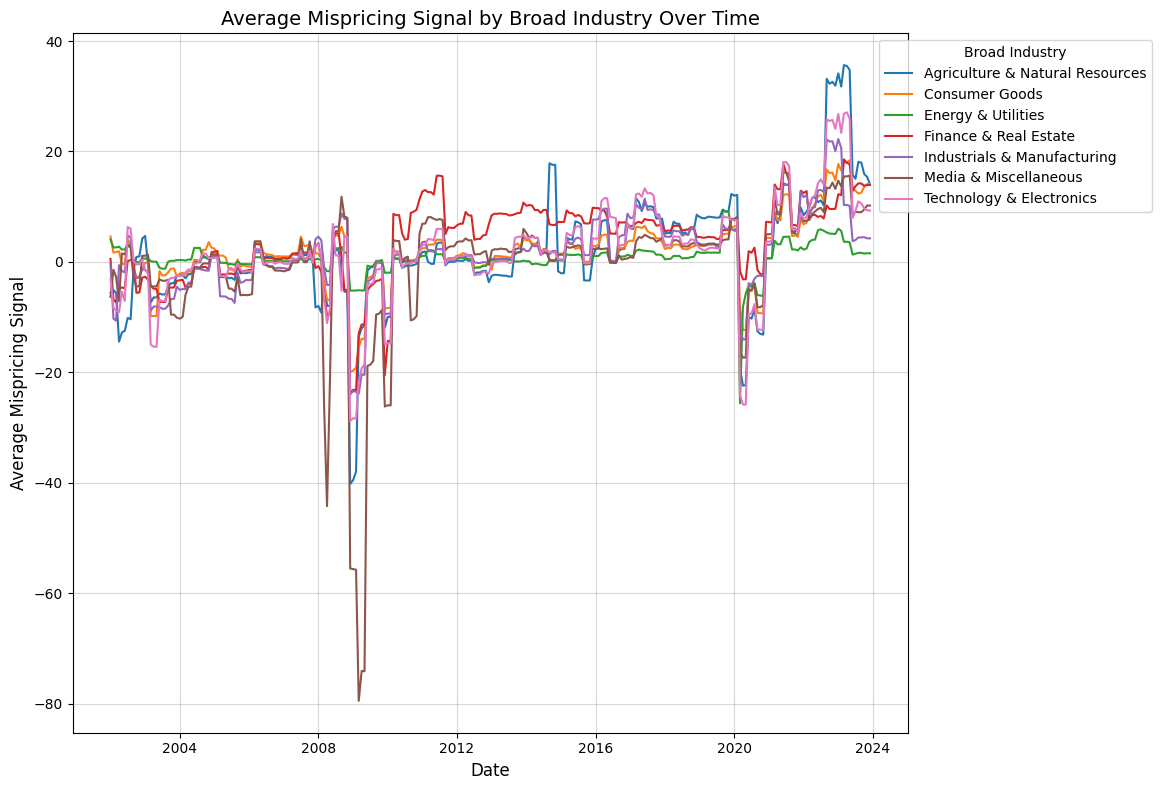

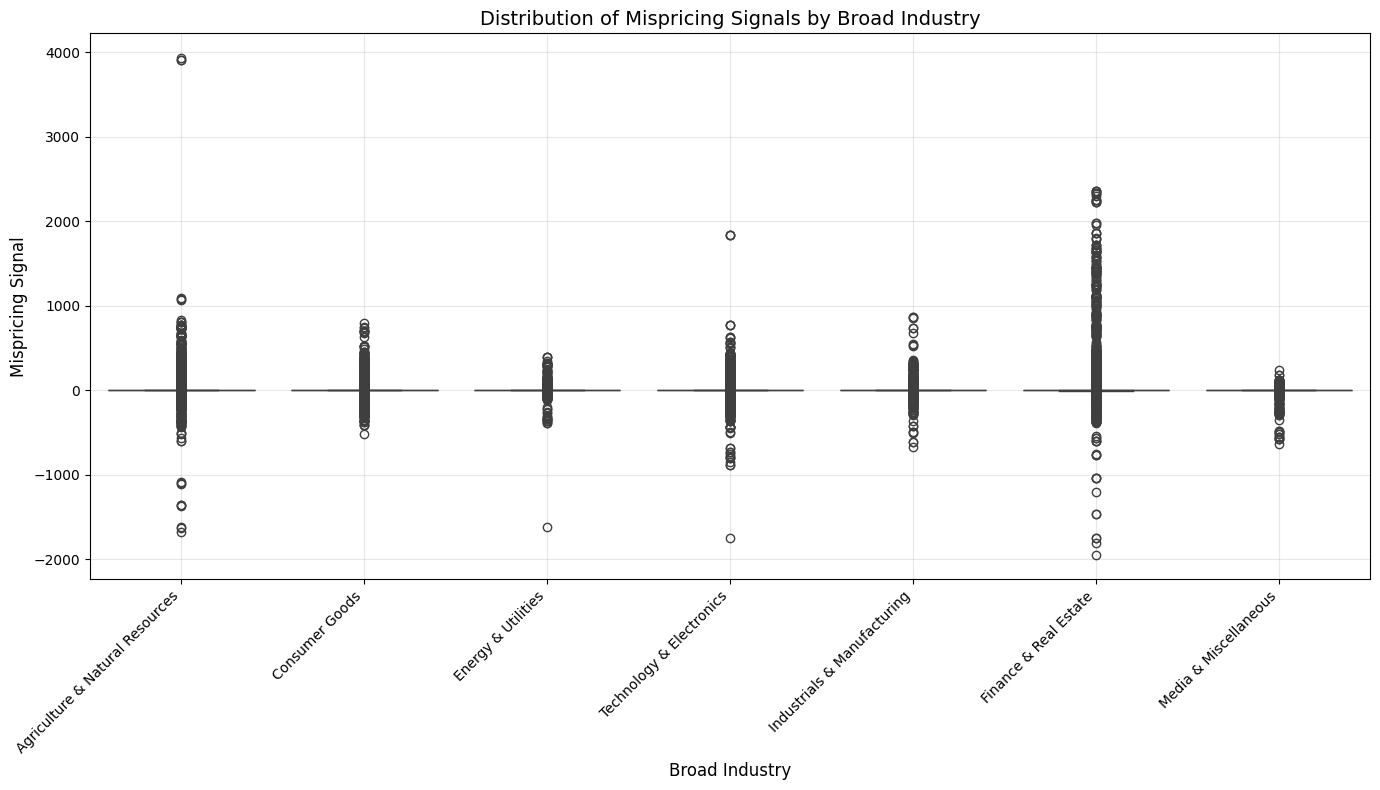

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define a broad mapping for industries
broad_industry_mapping = {
    'Agric': 'Agriculture & Natural Resources',
    'Mines': 'Agriculture & Natural Resources',
    'Metal': 'Agriculture & Natural Resources',
    'MtlPr': 'Agriculture & Natural Resources',
    'Stone': 'Agriculture & Natural Resources',
    'Chems': 'Agriculture & Natural Resources',
    'Apprl': 'Consumer Goods',
    'Chair': 'Consumer Goods',
    'Lethr': 'Consumer Goods',
    'Txtls': 'Consumer Goods',
    'Rtail': 'Consumer Goods',
    'Whlsl': 'Consumer Goods',
    'Ptrlm': 'Energy & Utilities',
    'Utils': 'Energy & Utilities',
    'Garbg': 'Energy & Utilities',
    'Electr': 'Technology & Electronics',
    'Instr': 'Technology & Electronics',
    'Phone': 'Technology & Electronics',
    'Machn': 'Technology & Electronics',
    'Money': 'Finance & Real Estate',
    'Manuf': 'Industrials & Manufacturing',
    'Cnstr': 'Industrials & Manufacturing',
    'Paper': 'Industrials & Manufacturing',
    'Rubbr': 'Industrials & Manufacturing',
    'Print': 'Media & Miscellaneous',
    'Smoke': 'Media & Miscellaneous',
    'Other': 'Media & Miscellaneous'
}

# Map industries to broad categories
df['Broad_Industry'] = df['industry'].map(broad_industry_mapping)

# Step 1: Calculate the average mispricing signal by broad industry over time
broad_industry_mispricing = (
    df.groupby(['date', 'Broad_Industry'])['Mispricing_Signal']
    .mean()
    .reset_index()
    .rename(columns={'Mispricing_Signal': 'Avg_Mispricing_Signal'})
)

# Step 2: Plot the trend of average mispricing signals across broad industries
plt.figure(figsize=(12, 8))
for industry in broad_industry_mispricing['Broad_Industry'].unique():
    subset = broad_industry_mispricing[broad_industry_mispricing['Broad_Industry'] == industry]
    plt.plot(subset['date'], subset['Avg_Mispricing_Signal'], label=industry)

plt.title('Average Mispricing Signal by Broad Industry Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Mispricing Signal', fontsize=12)
plt.legend(title='Broad Industry', loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# Step 3: Boxplot of mispricing signal distributions by broad industry
plt.figure(figsize=(14, 8))
sns.boxplot(x='Broad_Industry', y='Mispricing_Signal', data=df)
plt.title('Distribution of Mispricing Signals by Broad Industry', fontsize=14)
plt.xlabel('Broad Industry', fontsize=12)
plt.ylabel('Mispricing Signal', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()